# Testing notebook for work carried out by George 

Owner: George Hine

email: ppygh3@nottingham.ac.uk

In [2]:
import sys
sys.path.append('..')


In [3]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [4]:
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator
from matplotlib.patches import Circle

bands = np.array(['u','g','r','i','z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [5]:
# Want to create a dataset for galaxies nearby with high overal magnitude

# First sort the datasets 

#===========================================================================================

# open master fits and filter by face on spirals:

# Define location
path = '/home/borge/Data/gz2and1master.fits.gz'
# Access file
data = gfits.Read_Table(path)

# create masks for extraction 
mask_gz1 = data['gz1_arms_clean'] == True
mask_gz2 = data['gz2_arms_clean'] == True
# combine masks
mask = mask_gz1 + mask_gz2
# apply mask to data
face_on_master_table = data[mask]

# get collumn headers
column_names = list(face_on_master_table.columns.keys())
print(column_names)


['OBJID', 'OBJID_STR', 'RUN', 'RERUN', 'CAMCOL', 'FIELD', 'OBJ', 'RA', 'DEC', 'PETROR50_R', 'PETROR90_R', 'PETROMAG_U', 'PETROMAG_G', 'PETROMAG_R', 'PETROMAG_I', 'PETROMAG_Z', 'PETROMAGERR_U', 'PETROMAGERR_G', 'PETROMAGERR_R', 'PETROMAGERR_I', 'PETROMAGERR_Z', 'PSFMAG_R', 'FIBERMAG_R', 'DEVMAG_R', 'DEVMAGERR_R', 'EXPMAG_R', 'EXPMAGERR_R', 'FRACDEV_R', 'MU50_R', 'EXTINCTION_U', 'EXTINCTION_G', 'EXTINCTION_R', 'EXTINCTION_I', 'EXTINCTION_Z', 'ROWC_U', 'COLC_U', 'ROWC_G', 'COLC_G', 'ROWC_R', 'COLC_R', 'ROWC_I', 'COLC_I', 'ROWC_Z', 'COLC_Z', 'CMODELMAG_R', 'CMODELMAGERR_R', 'REDSHIFT', 'REDSHIFTERR', 'PETROMAG_MU', 'PETROMAG_MG', 'PETROMAG_MR', 'PETROMAG_MI', 'PETROMAG_MZ', 'PETROMAGERR_MU', 'PETROMAGERR_MG', 'PETROMAGERR_MR', 'PETROMAGERR_MI', 'PETROMAGERR_MZ', 'PETROR50_R_KPC', 'REGION', 'PETROR50_R_KPC_SIMPLE_BIN', 'PETROMAG_MR_SIMPLE_BIN', 'REDSHIFT_SIMPLE_BIN', 'WVT_BIN', 'sample', 'asset_id', 'total_count', 'total_weight', 't01_smooth_or_features_a01_smooth_weight', 't01_smooth_or_fe

In [6]:
# First sort by redshift and select only the closest 25%

z_sorted = face_on_master_table[np.argsort(face_on_master_table['REDSHIFT'])]
z_sorted = z_sorted[:int(len(z_sorted)*0.25)]

# Now sort by overall size and select the biggest 25%
PETROR50_R_KPC_sorted = face_on_master_table[np.argsort(face_on_master_table['PETROR50_R_KPC'])]
PETROR50_R_KPC_sorted = PETROR50_R_KPC_sorted[:int(len(PETROR50_R_KPC_sorted)*0.25)]

# Now maximise spiral features
t04_spiral_a08_spiral_weighted_fraction_sorted = face_on_master_table[np.argsort(face_on_master_table['t04_spiral_a08_spiral_weighted_fraction'])]
t04_spiral_a08_spiral_weighted_fraction_sorted = t04_spiral_a08_spiral_weighted_fraction_sorted[:int(len(t04_spiral_a08_spiral_weighted_fraction_sorted)*0.25)]

t04_spiral_a08_spiral_weighted_fraction_sorted


<Table length=7312>
      OBJID             OBJID_STR       ... arms_clean_union
      int64               str20         ...       bool      
------------------ -------------------- ... ----------------
587722982825656587 587722982825656587   ...             True
587738371667919334 587738371667919334   ...             True
587731172771037636 587731172771037636   ...             True
587742611346882591 587742611346882591   ...             True
588017702928056434 588017702928056434   ...             True
587741601489420330 587741601489420330   ...             True
588016891169603777 588016891169603777   ...             True
587739296700563633 587739296700563633   ...             True
587731187807813917 587731187807813917   ...             True
587738574605320364 587738574605320364   ...             True
               ...                  ... ...              ...
587733412593074295 587733412593074295   ...             True
587737933044449514 587737933044449514   ...             True
587732134841221192 587732134841221192   ...             True
587733604258283683 587733604258283683   ...             True
587733604262740046 587733604262740046   ...             True
587741815713234950 587741815713234950   ...             True
587728879802253480 587728879802253480   ...             True
587739505012375613 587739505012375613   ...             True
588017114520092839 588017114520092839   ...             True
587735342653374661 587735342653374661   ...             True

In [7]:

def filter_table(table, column_name, lower_bound, upper_bound):
    """
    Filters an Astropy Table object between two values given a column to filter by.
    
    Parameters
    ----------
    table : `astropy.table.Table`
        The Astropy Table object to filter.
    column_name : `str`
        The name of the column to filter by.
    lower_bound : `float`
        The lower bound of the filter range.
    upper_bound : `float`
        The upper bound of the filter range.
    
    Returns
    -------
    filtered_table : `astropy.table.Table`
        The filtered Astropy Table object.
    """
    mask = (table[column_name] >= lower_bound) & (table[column_name] <= upper_bound)
    filtered_table = table[mask]
    return filtered_table


In [8]:
mask = (face_on_master_table['t04_spiral_a08_spiral_weighted_fraction'] >= 0.9) & (face_on_master_table['t04_spiral_a08_spiral_weighted_fraction'] <= np.max(face_on_master_table['t04_spiral_a08_spiral_weighted_fraction'])) & (face_on_master_table['PETROR50_R_KPC'] >= np.mean(face_on_master_table['PETROR50_R_KPC'])) & (face_on_master_table['PETROR50_R_KPC'] <= np.max(face_on_master_table['PETROR50_R_KPC']))
filtered_spirals_face_on_master_table = face_on_master_table[mask]

# Cool so now have a data set of objects all confirmed to be spirals by humans!

# Now will sort by the brightest and select top 1000
# require highest average magnitude

avg_mag = np.average([filtered_spirals_face_on_master_table['U'],filtered_spirals_face_on_master_table['G'],
            filtered_spirals_face_on_master_table['R'],filtered_spirals_face_on_master_table['I'],
            filtered_spirals_face_on_master_table['Z']],axis=0)

mask = np.argsort(avg_mag)
#filtered_brightest_1000_spirals_face_on_master_table = filtered_spirals_face_on_master_table
#[:1000]
print(mask,filtered_spirals_face_on_master_table[mask][:1000]['U']) # Increasing so sorted by brightest first!

bright_spirals = filtered_spirals_face_on_master_table[mask][:1000]
print(bright_spirals[:100])


[8988  660 2449 ... 3622 7749 8640]         U         
------------------
14.926456451416016
15.493609428405762
14.766825675964355
15.597561836242676
15.811606407165527
15.352490425109863
14.965958595275879
15.184021949768066
 16.17160415649414
15.389115333557129
               ...
  16.7091064453125
  16.7746639251709
 17.46084976196289
 17.04378890991211
17.016414642333984
 16.96625328063965
 16.90428924560547
17.116348266601562
17.303159713745117
17.008472442626953
 17.07647705078125
Length = 1000 rows
      OBJID             OBJID_STR       ... arms_clean_union
------------------ -------------------- ... ----------------
588017702930022421 588017702930022421   ...             True
587726031719301138 587726031719301138   ...             True
587732591714893851 587732591714893851   ...             True
587741603105210388 587741603105210388   ...             True
587734623237111983 587734623237111983   ...             True
587741723357282317 587741723357282317   ...             True
5

In [9]:
candidate_list = np.asarray(bright_spirals['OBJID_STR'],dtype=str)
candidate_list = [s[:-2] for s in candidate_list]
# Write to a text file
with open('Brightest_1000_Spirals.txt', "w") as f:
    for s in candidate_list:
        f.write(s + "\n")

candidate_list[:100]


['588017702930022421',
 '587726031719301138',
 '587732591714893851',
 '587741603105210388',
 '587734623237111983',
 '587741723357282317',
 '587732577773420642',
 '588848900983357543',
 '587731173306663288',
 '587741816240799826',
 '588009368545984617',
 '587741722823884873',
 '588015508748501057',
 '587733399190569078',
 '587741603110977632',
 '588017625623560200',
 '587732483837067338',
 '588297864726642799',
 '587738951489486893',
 '587742578050203720',
 '587735742617616406',
 '587741722823950350',
 '588010358548070424',
 '587734622171168831',
 '587738411398004813',
 '588017724407545981',
 '587741532774858770',
 '587742014903943216',
 '588018056733130844',
 '588015510347448339',
 '587737826756198431',
 '588017979966947360',
 '588009365861498889',
 '587742062143013024',
 '588017111835344908',
 '587731511532847214',
 '588017992312684614',
 '587742616173740156',
 '587729652349141047',
 '587731891111788592',
 '587736915142574202',
 '588017949357965355',
 '587739407841165563',
 '588013384

In [10]:
# Cool so now want to make a list of the filenames for copying to the server

with open('Brightest_1000_Spirals_filenames.txt', "w") as f:
    for s in candidate_list:
        f.write(s + "ua.fits.gz\n")
        f.write(s + "ga.fits.gz\n")
        f.write(s + "ra.fits.gz\n")
        f.write(s + "ia.fits.gz\n")
        f.write(s + "za.fits.gz\n")


In [11]:
# Want to look at the offset of spiral arm pattern and difference in winding angle across bands

# First get the information of a good test image
Test_table, Test_composite = gfits.Composite_from_directory_raid('587731892188545037','/home/borge/Data/Output_Data/Distributed_run/')

In [12]:
Test_table

<Table length=5>
       log_n               log_re       ... Band Effective Wavelength
     float64[1]          float64[1]     ... str1       float64       
-------------------- ------------------ ... ---- --------------------
  0.1981763213665715 1.4195590600786647 ...    u            3.543e-07
 0.16427275096377766 1.7310352568503051 ...    g             4.77e-07
  0.1913710917322307 1.7061528839065312 ...    r            6.231e-07
 0.10548195155490021 1.7062069145416332 ...    i            7.625e-07
0.044427296396491865  1.707233229595326 ...    z            9.134e-07

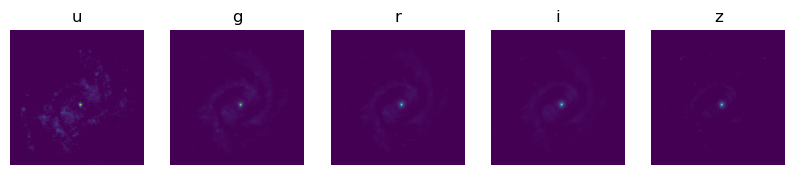

In [13]:
gfits.Composite_imshow(Test_composite)

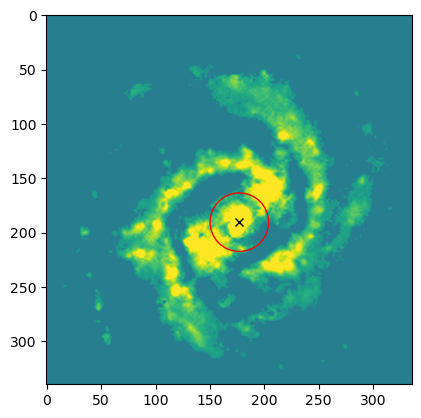

In [14]:
# Now need to run SFT on each band and look at the output

# First get estimate of the R_min using the Spiral fourier transform function
img = Test_composite[:,:,1]
table = Test_table[1]


# Plot the R_e multiple on the image
R_e_multiple = 0.5
R_e = 10**table['log_re']
x0 = table['x'] + img.shape[1]/2
y0 = table['y'] + img.shape[0]/2
r_min = Circle((x0,y0),R_e_multiple*R_e,color='r',fill=False)

# Show the image
fig, ax = plt.subplots()
ax.imshow(img,vmin=np.mean(img)-2*np.std(img),vmax=np.mean(img)+2*np.std(img))
ax.add_patch(r_min)
ax.plot(x0,y0,'kx')
# Will make this into a function for easy diagnosing


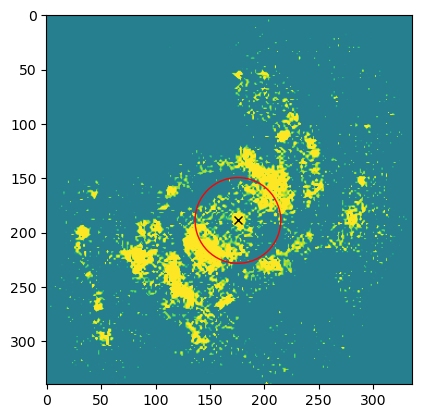

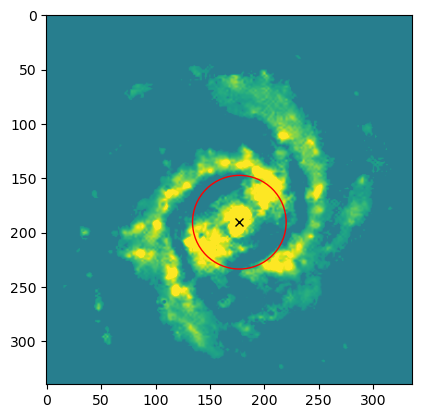

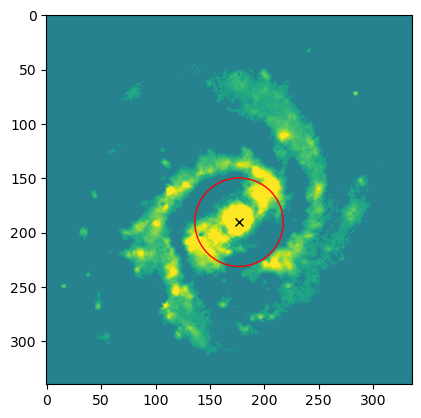

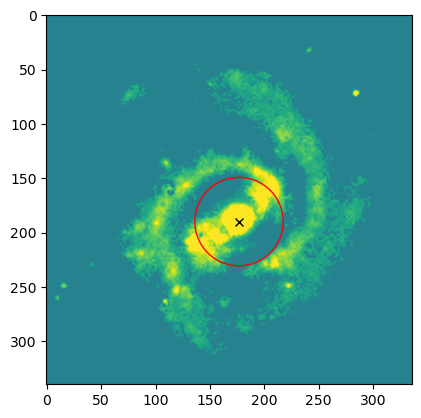

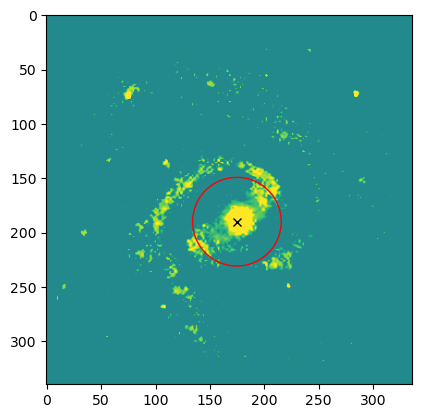

In [15]:
def estimate_r_min_multiple(img,table,R_e_multiple):
    R_e = 10**table['log_re']
    x0 = table['x'] + img.shape[1]/2
    y0 = table['y'] + img.shape[0]/2
    r_min = Circle((x0,y0),R_e_multiple*R_e,color='r',fill=False)

    # Show the image
    fig, ax = plt.subplots()
    ax.imshow(img,vmin=np.mean(img)-2*np.std(img),vmax=np.mean(img)+2*np.std(img))
    ax.add_patch(r_min)
    ax.plot(x0,y0,'kx')

estimate_r_min_multiple(Test_composite[:,:,0],Test_table[0],1.5) # Nice 
estimate_r_min_multiple(Test_composite[:,:,1],Test_table[1],0.8)
estimate_r_min_multiple(Test_composite[:,:,2],Test_table[2],0.8)
estimate_r_min_multiple(Test_composite[:,:,3],Test_table[3],0.8)
estimate_r_min_multiple(Test_composite[:,:,4],Test_table[4],0.8)

(1, 1) [175]
(1, 1) [175]
Winding angle φ = None - No pattern identified
(1, 1) [177]


/home/borge/spiral_arms/George/gax_fits.py:659: RuntimeWarning: overflow encountered in exp
  r = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi))))
/home/borge/spiral_arms/George/gax_fits.py:669: RuntimeWarning: invalid value encountered in matmul
  rotated_vector = rot_mat @ vector


(1, 1) [177]
Winding angle φ = 14.036243467926885  Pattern position angle θ =  -0.3377109920349971
(1, 1) [176]
(1, 1) [176]
Winding angle φ = 14.931417178138025  Pattern position angle θ =  -4.153201664612639
(1, 1) [176]
(1, 1) [176]
Winding angle φ = 14.56027561935732  Pattern position angle θ =  -10.009417846906976
(1, 1) [174]
(1, 1) [174]
Winding angle φ = 15.73200478510784  Pattern position angle θ =  0.1713335309174726


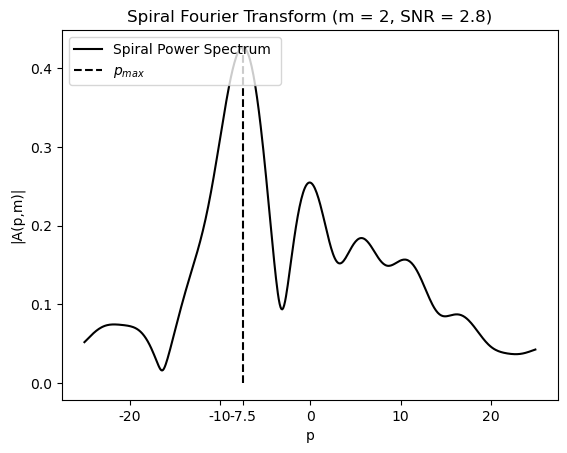

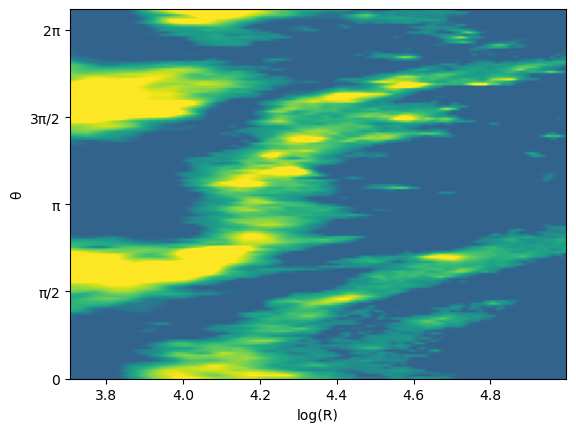

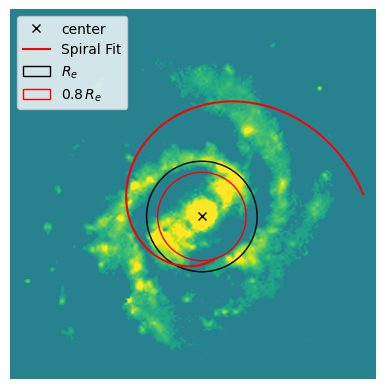

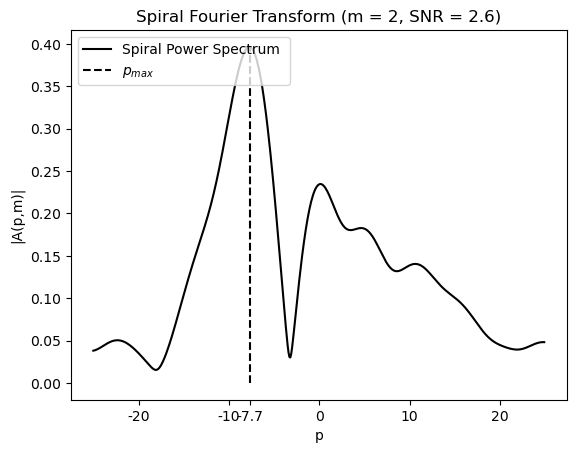

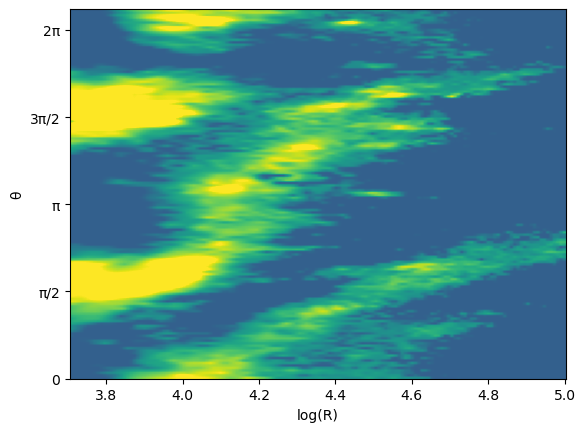

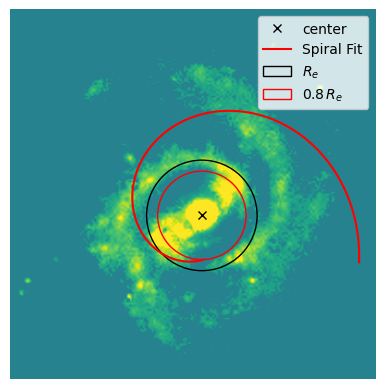

In [16]:
phi_u, theta_u = gfits.Spiral_Fourier_Transform(Test_composite[:,:,0],Test_table[0],1.5,2,False,False)
phi_g, theta_g = gfits.Spiral_Fourier_Transform(Test_composite[:,:,1],Test_table[1],0.8,2,False,False)
phi_r, theta_r = gfits.Spiral_Fourier_Transform(Test_composite[:,:,2],Test_table[2],0.8,2,True,False)
phi_i, theta_i = gfits.Spiral_Fourier_Transform(Test_composite[:,:,3],Test_table[3],0.8,2,True,False)
phi_z, theta_z = gfits.Spiral_Fourier_Transform(Test_composite[:,:,4],Test_table[4],0.8,2,False,False)

# So the U band is failing, fine the data is just not good enough
winding_angles = np.array([phi_u,phi_g,phi_r,phi_i,phi_z])
pattern_position_angles = np.array([theta_u,theta_g,theta_r,theta_i,theta_z])

In [17]:
# Now want to look at offset of the pattern position 
np.degrees(pattern_position_angles)

array([ -1.97687679,  -0.33771099,  -4.15320166, -10.00941785,
         0.17133353])

In [18]:
# Want to make a function that uses the difference in R_e to work out if 
# its going to be possible to classify one for whole

def consistent_R_e_mask(OBJID,parent_dir):
    # First get composite table
    table, comp = gfits.Composite_from_directory_raid(OBJID,parent_dir)

    # get the values of R_e out
    R_e = 10**table['log_re']
    # exclude the u band
    R_e = np.asarray(R_e[1:])
    # theres is probably a way to do this with standard deviation - need to think
    std = np.std(R_e)

    if std < 10:
        return True
    else:
        return False




In [19]:
Bool = consistent_R_e_mask('587731892188545037','/home/borge/Data/Output_Data/Distributed_run/')
Bool

True

In [20]:
# Need to run this over the directory list to create a mask
candidates = np.loadtxt('/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/directories.txt',dtype=str)

new_array = []
for s in candidates:
    new_s = s[:-2]
    new_array.append(new_s)
candidates = np.unique(np.asarray(new_array))

failures = np.array(['588023670779281517','587742573761855511','587739720303181999',
           '587744729298239519','587731173306663288','587735349099954195'])
failure_mask = np.isin(candidates, failures)
candidates = candidates[~failure_mask]

file_name = 'dos.txt'
with open(file_name, mode="w", encoding="utf-8") as file:
    for string in candidates:
        file.write(string + "\n")  # Add a newline character after each string
print(os.getcwd())

R_e_mask = np.empty(len(candidates))

/home/borge/spiral_arms/George


In [21]:
for i in range(0,len(candidates)):
    R_e_mask[i] = consistent_R_e_mask(candidates[i],'/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/')
    

In [22]:
# This isn't going to work anyway beacuse the centers are different

In [23]:
# Shivani's Code

from astropy.table import vstack, hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky

# Load the first table
table1 = Table.read('gz2and1master.fits')

# Load the second table
table2 = Table.read('nsa_v0_1_2.fits')

# Define the coordinate system for both tables
coords1 = SkyCoord(ra=table1['RA']*u.degree, dec=table1['DEC']*u.degree)
coords2 = SkyCoord(ra=table2['RA']*u.degree, dec=table2['DEC']*u.degree)

# Find the nearest matches within a certain radius
idx, d2d, d3d = match_coordinates_sky(coords2, coords1, nthneighbor=1)

ok = d2d < 1 * u.arcsec
idx = idx[ok]

# Create a new table with matched rows
matched_table1 = table1[idx]
matched_table2 = table2[d2d < 1*u.arcsec]

# Print the matched table
#print(matched_table)

# Write the joined table to a new FITS file
#matched_table.write('matched_table.fits', overwrite=True)

#%%

matched = hstack([matched_table1, matched_table2])

# Print the matched table
print(matched)

# Write the joined table to a new FITS file
matched.write('matched_table.fits', overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: 'gz2and1master.fits'

983 2017


(-0.5, 315.5, 355.5, -0.5)

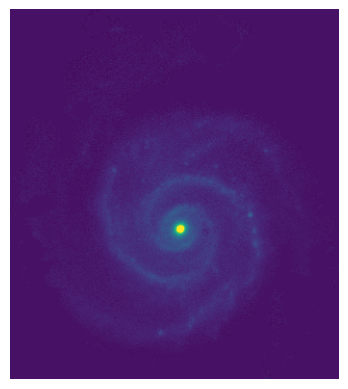

In [24]:
image = gfits.Read('/home/borge/Data/Test_batch/587732050555961424ra.fits.gz')
print(np.min(image),np.max(image))
plt.imshow(image,vmin=980,vmax=1400)
plt.axis('off')

In [25]:
# Need to run ficl on a spiral with a high iteration frequency to create the animation
file_list = np.array(['587732050555961424ra.fits.gz'])
data_location = '/home/borge/Data/Test_batch'
config_path = '/home/borge/Data/Config_files'
output_path = '/home/borge/Data/Extraction_animation'

#gfits.command_line_file_list_run(file_list,data_location,config_path,output_path)

In [26]:
# Need to make a function which reads all the images into a single folder so that i can open it in DS9

# create an array of folder names:

# First get the numbers
numbers = np.arange(1,201).astype(int) 

# Put these into the correct string format
folder_strings = [f"{num:04d}" for num in numbers]


In [27]:
import shutil

# Now need to go through all the folders and copy the files to a separate folder
parent_dir      = '/home/borge/Data/Extraction_animation/587732050555961424ra'
destination_dir = '/home/borge/Data/Extraction_animation/small_non_par/'

for i in range(0,len(folder_strings)):
    os.chdir(parent_dir)
    os.chdir(folder_strings[i])
    current_loc = os.getcwd()
    source_file = current_loc + '/small_nonpar.fits'
    destination_file = destination_dir + folder_strings[i] + '.fits'
    shutil.copy(source_file,destination_file)
    
    
    


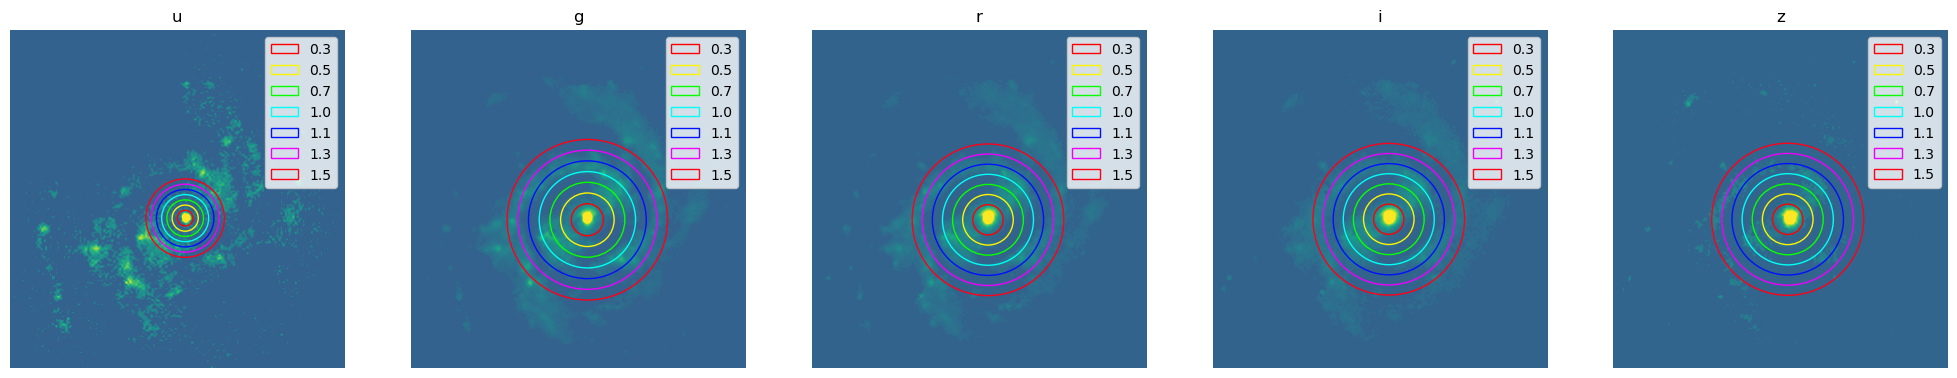

In [28]:
# Need to make a human diagnosis tool for estimating the excluded region

# Need to augment multiband imshow to plot successive anuli on image around the fit center as multiples of R_e

# get the test image and table

table, image = gfits.Composite_from_directory_raid('587731892188545037','/home/borge/Data/Output_Data/Distributed_run/')

# create an array of multiples from 0.3-1.5?

R_e_multiples = np.arange(0.3,1.51,0.2)

# Get center and R_e out of the table

R_e = np.asarray(10**table['log_re'])
x0 = np.asarray(table['x']) + image.shape[1]/2
y0 = np.asarray(table['y']) + image.shape[0]/2


# Begin plotting

colours =  plt.cm.hsv(np.linspace(0,1,len(R_e_multiples)))

fig, ax = plt.subplots(1,5,figsize=(25, 25))

for i in range(0,len(bands)):
    ax[i].imshow(image[:,:,i],vmin=np.mean(image[:,:,i])-5*np.std(image[:,:,i]),vmax=np.mean(image[:,:,i])+10*np.std(image[:,:,i]))
    ax[i].set_title('{}'.format(bands[i]))
    ax[i].axis('off')
    for j in range(0,len(R_e_multiples)):
        loop_patch = Circle((x0[i],y0[i]),R_e_multiples[j]*R_e[i],color=colours[j], facecolor=None, fill=False)
        ax[i].add_patch(loop_patch)
    ax[i].legend(['{}'.format(R_e_multiples[0]),'{}'.format(R_e_multiples[1]),'{}'.format(R_e_multiples[2]),'{}'.format(np.around(R_e_multiples[3]),1),'{}'.format(R_e_multiples[4]),'{}'.format(R_e_multiples[5]),'1.5'])

# Nice make into function

In [29]:
def r_min_diagnosis(OBJID,parent_dir):
    table, image = gfits.Composite_from_directory_raid(OBJID,parent_dir)

    # create an array of multiples from 0.3-1.5?

    R_e_multiples = np.arange(0.3,1.51,0.2)

    # Get center and R_e out of the table

    R_e = np.asarray(10**table['log_re'])
    x0 = np.asarray(table['x']) + image.shape[1]/2
    y0 = np.asarray(table['y']) + image.shape[0]/2


    # Begin plotting

    colours =  plt.cm.hsv(np.linspace(0,1,len(R_e_multiples)))

    fig, ax = plt.subplots(1,5,figsize=(25, 25))
   
    for i in range(0,len(bands)):
        ax[i].imshow(image[:,:,i],vmin=np.mean(image[:,:,i])-7.5*np.std(image[:,:,i]),vmax=np.mean(image[:,:,i])+7.5*np.std(image[:,:,i]))
        if i == 0:
            ax[i].set_title('{} {}'.format(OBJID,bands[i]))
        else:
            ax[i].set_title('{}'.format(bands[i]))
        ax[i].axis('off')
        for j in range(0,len(R_e_multiples)):
            loop_patch = Circle((x0[i],y0[i]),R_e_multiples[j]*R_e[i],color=colours[j], facecolor=None, fill=False)
            ax[i].add_patch(loop_patch)
        ax[i].legend(['{}'.format(R_e_multiples[0]),'{}'.format(R_e_multiples[1]),'{}'.format(R_e_multiples[2]),'{}'.format(np.around(R_e_multiples[3]),1),'{}'.format(R_e_multiples[4]),'{}'.format(R_e_multiples[5]),'1.5'])

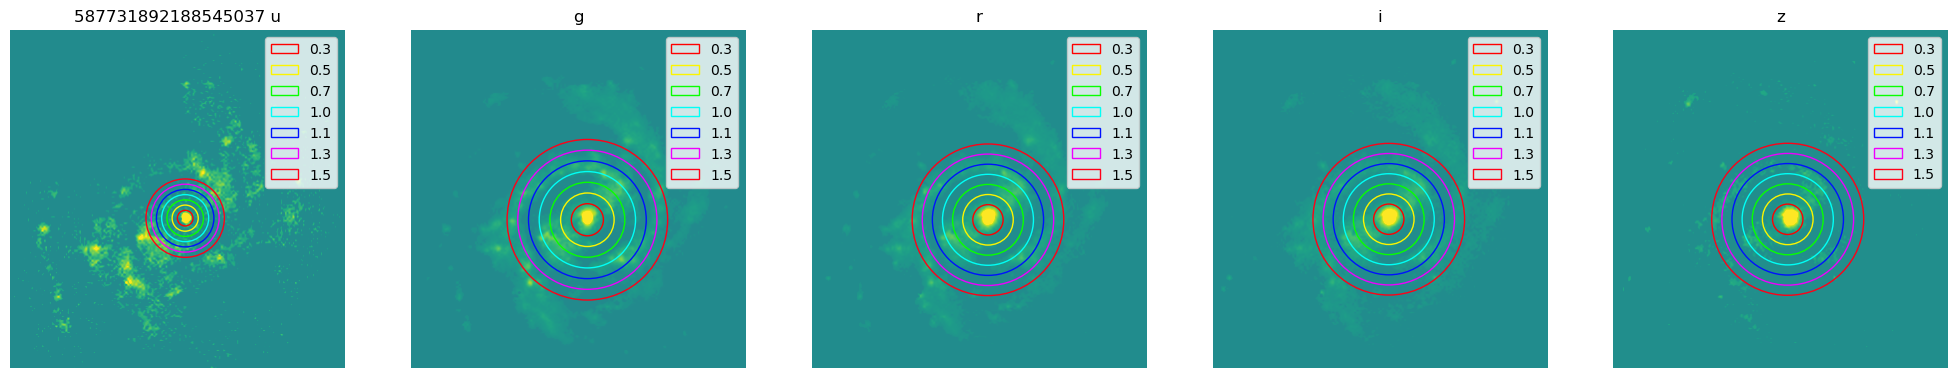

In [30]:
r_min_diagnosis('587731892188545037','/home/borge/Data/Output_Data/Distributed_run/')

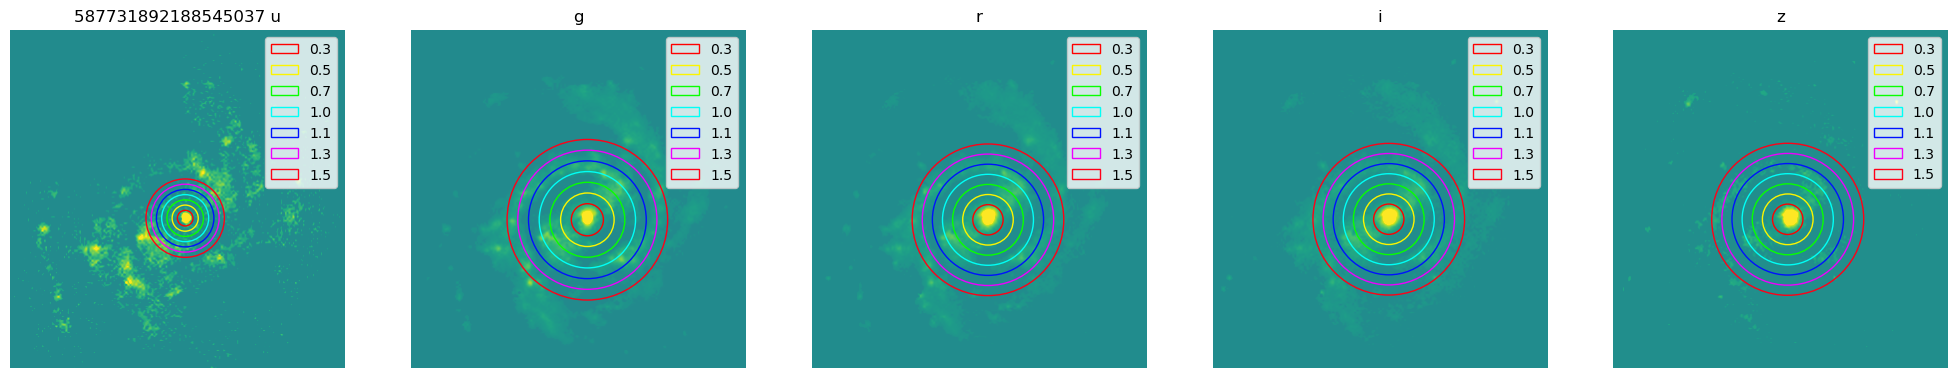

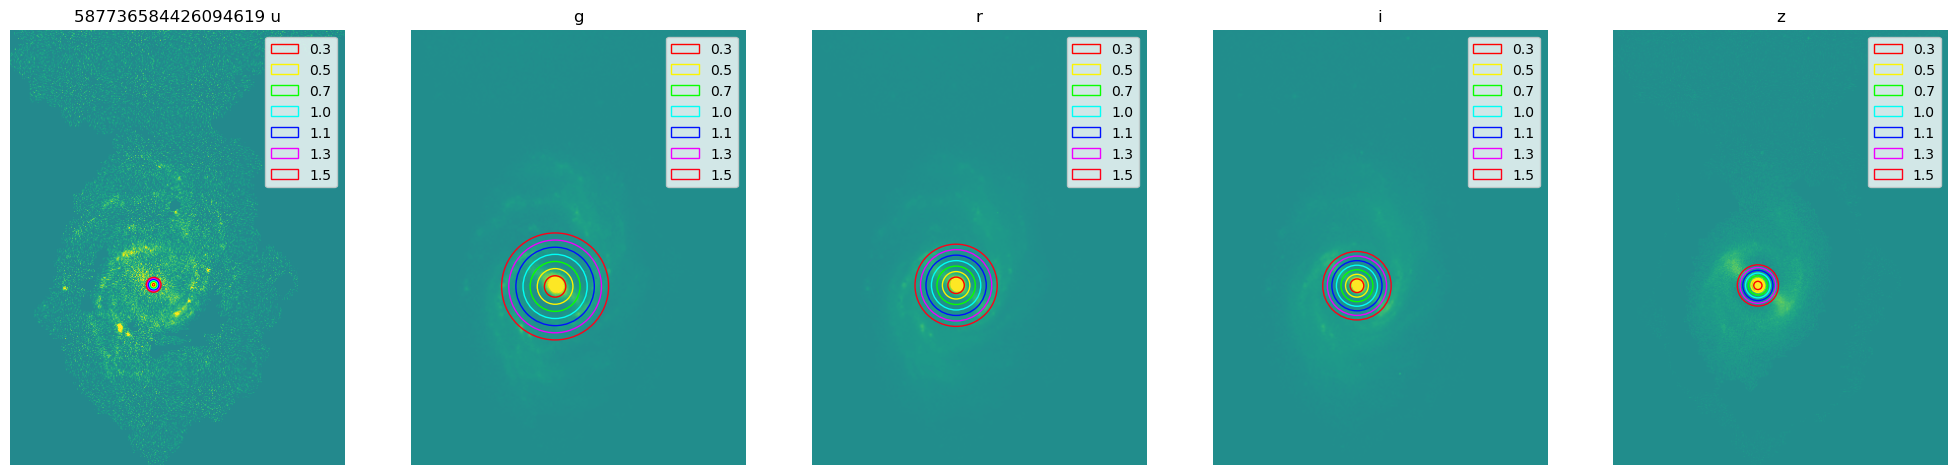

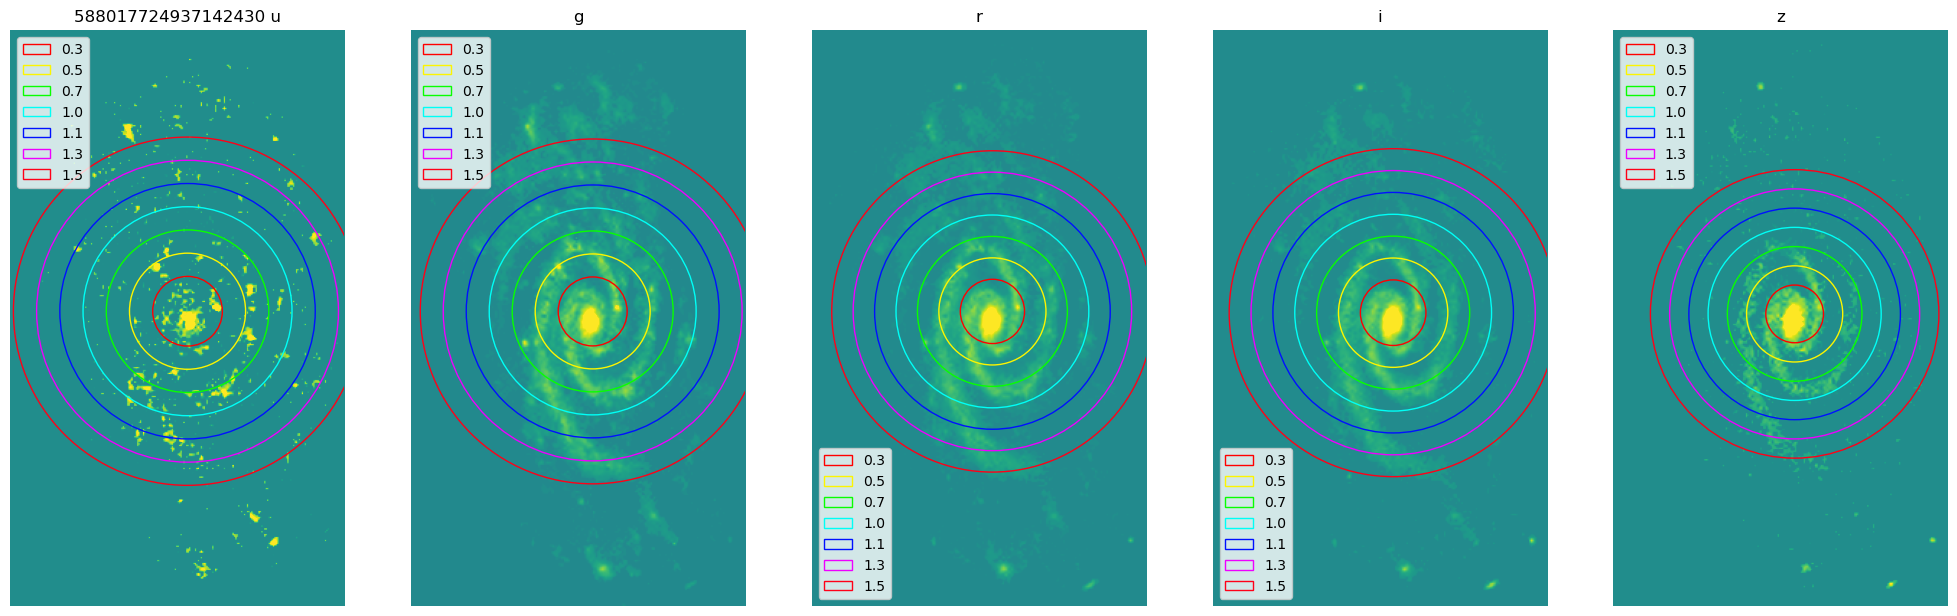

In [31]:
candidate_list = np.array(['587731892188545037','587736584426094619','588017724937142430'])
parent_dir = '/home/borge/Data/Output_Data/Distributed_run/'

for i in range(0,len(candidate_list)):
    r_min_diagnosis(candidate_list[i],parent_dir)
    

(1, 1) [177]
(1, 1) [177]
Winding angle φ = 16.62075691389267  Pattern position angle θ =  11.6689215940931


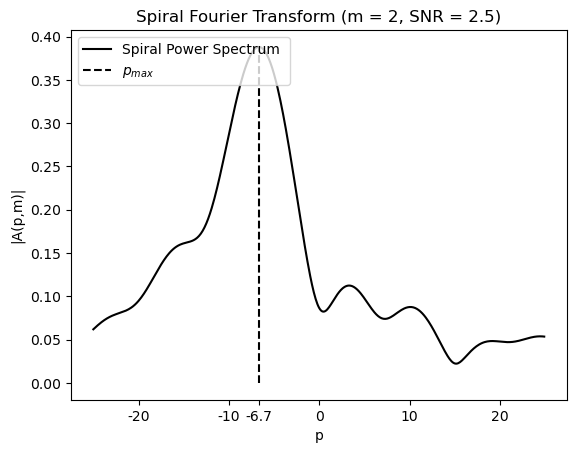

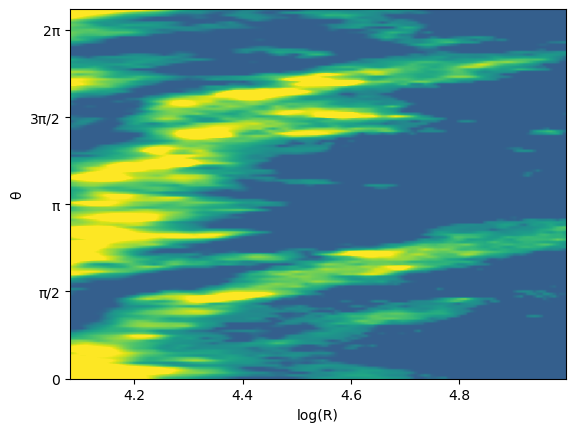

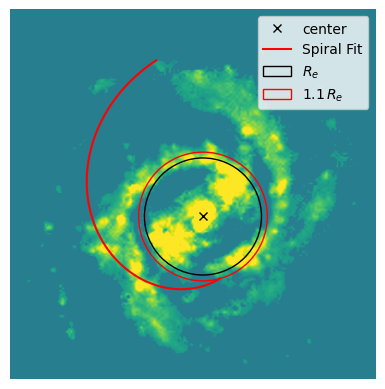

In [32]:
phi, theta = gfits.Spiral_Fourier_Transform(image[:,:,1],table[1],1.1,2,True,False)

In [33]:
# Now need a function for just diplaying the fit

def fit_overlay(Image,Table,R_min_multiple,m):
    
    
    img = Image
    Tab = Table
    # First collect image info from Table
    x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
    y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
    R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
    log_R_e = np.asarray(Tab['log_re']) # log effective radius
    log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
    pa = np.asarray(Tab['theta']) # position angle
    q = np.asarray(Tab['q']) # axis ratio
    
    
    # Get the dimensions of the Image
    height, width = img.shape[:2]   

    # Calculate the maximum possible radius
    max_radius = min(x0, y0, width-x0, height-y0)
    max_R = max_radius -1
    
    # Create x and y index arrays
    y, x = np.indices(img.shape)
    
    # Center index arrays
    x -= x0
    y -= y0
    
    # Deprojecting x,y by a series of affine transformations

    # Rotate by minus position angle
    ct = np.cos(-pa)
    st = np.sin(-pa)

    # Stretch according to axis ratio and rotation
    xp = (y * ct + x * st) / q
    yp = (-y * st + x * ct)

    # Convert to Polar
    rp2 = xp ** 2 +  yp ** 2
    rp = np.sqrt(rp2)
    tp = np.arctan2(yp, xp)
    
    # Define ln(r),theta image dimensions
    n_lnr = 150
    n_theta = 150
    
    # Create index arrays
    lnr, theta = np.indices((n_lnr, n_theta))
    
    # Define bounds for image dimensions
    lnr_min = float(log_R_e_05)
    lnr_max = float(np.log(int(max_R) -1))
    theta_max = 360
    lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
    theta = theta * theta_max / n_theta
    
    # Create yticks arrays
    lnr_y_axis = np.linspace(lnr_min,lnr_max,5)
    
    # Define xp and yp in terms of new coord system
    xp = np.exp(lnr) * np.sin(np.radians(theta))
    yp = np.exp(lnr) * np.cos(np.radians(theta))
    
    # this is an attempt at using the above deprojection code
    # to do the inverse by pa -> -pa and q -> 1/q   
    ct = np.cos(pa)
    st = np.sin(pa)
    x = (yp * ct + xp * st) * q
    y = (-yp * st + xp * ct)
    x += y0
    y += x0
    
    # Create a Regular grid from interpolation
    img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])), img)
    
    # Define allowed indices
    ok = (x >= 0) & (x < img.shape[0] - 1) 
    ok &= (y >= 0) & (y < img.shape[1] - 1) 
    
    # Create image from interpolation
    img_lnr_theta = img_interp((x, y))
    
    # Use broadcasting to do multiple p at once
    p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
    weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
    D = img_lnr_theta.sum()
    A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
    A_p_m = 1/D *(img_lnr_theta * weight).sum((-1, -2))
    
    # Calculate winding angle from maximum of Spiral Power spectrum
    p_max = p.ravel()[A.argmax()]
    phi = np.degrees(np.arctan(-m/p_max))#
    
    # Generate spiral for plotting
    x_,y_, argument = gfits.gen_spiral(p_max,A_p_m,m,R_e,R_min_multiple,img,x0[0],y0[0])
    
    if 88<phi<92 or -88>phi>-92:
        print('Winding angle \u03C6 =',None,'- No pattern identified')
    else:
        print('Winding angle \u03C6 =', phi,' Pattern position angle \u03B8 = ',np.degrees(argument))
        
    
    
    # Calculate signal to Noise
    SN_m, SN_w = gfits.SN(A_p_m)

    # Labeled galaxy Image
    fig, ax = plt.subplots()
    ax.imshow(img.T,vmin=np.mean(img)-2*np.std(img),vmax=np.mean(img)+2*np.std(img))

    # Define circle
    R_e_1 = Circle((x0,y0),R_e,edgecolor='black', facecolor=None, fill=False)
    R_e_05 = Circle((x0,y0),R_min_multiple*R_e,edgecolor='red', facecolor=None, fill=False)
    
    ax.plot(x0,y0,'xk')
    ax.plot(x_,y_,'r-')
    
    ax.add_patch(R_e_1)
    ax.add_patch(R_e_05)
    ax.legend(['center','Spiral Fit','$R_e$','${}\, R_e$'.format(R_min_multiple)])
    ax.axis('off')
    

Winding angle φ = 16.62075691389267  Pattern position angle θ =  11.6689215940931


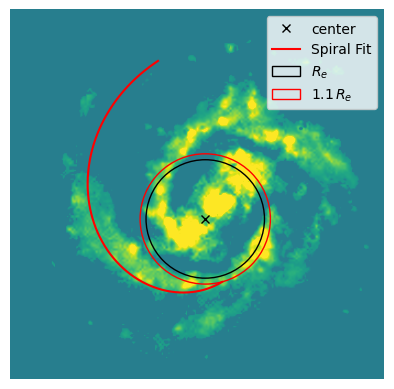

In [34]:
fit_overlay(image[:,:,1],table[1],1.1,2)

In [35]:
# Want to create a function which takes an image and returns the image with the bulge removed
table, comp = gfits.Composite_from_directory_raid('587725469600055395','/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/')

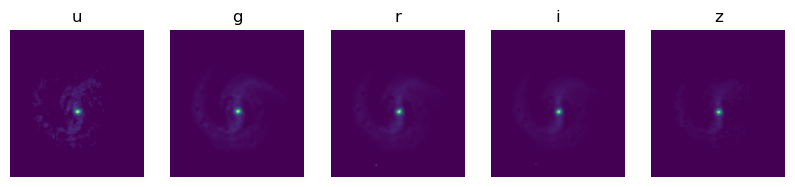

In [36]:
gfits.Composite_imshow(comp)

<Row index=1>
       log_n              log_re              mag                 q                theta                x                 y         Band Effective Wavelength
     float64[1]         float64[1]         float64[1]         float64[1]         float64[1]         float64[1]        float64[1]    str1       float64       
------------------- ------------------ ------------------ ------------------ ------------------ ------------------ ---------------- ---- --------------------
-0.0586385500606021 1.4771363641918005 -13.84711925606083 0.8913909926197665 0.9757733428353216 0.9901598150245969 8.37869773964676    g             4.77e-07

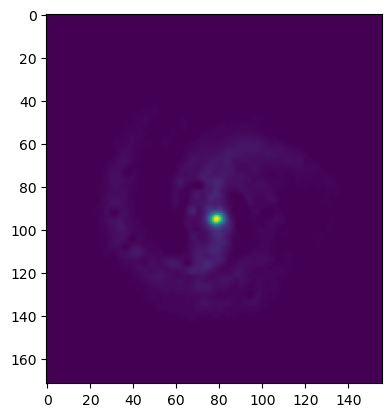

In [37]:
# Get an image:
img = comp[:,:,1]
tbl = table[1]
plt.imshow(img)
tbl

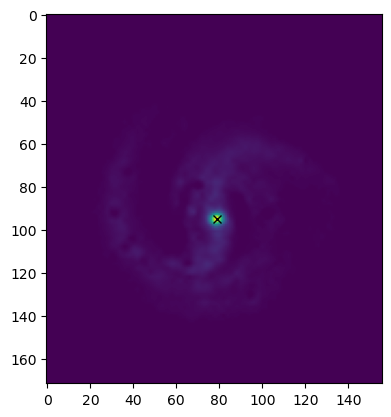

In [38]:
# Find the image index with the brightest pixel (most likely in the bulge)
bulge_intensity = np.max(img)
bulge_pos = np.argwhere(img == bulge_intensity)
bulge_pos = np.asarray(bulge_pos)

plt.imshow(img)
plt.plot(bulge_pos[0,1],bulge_pos[0,0],'kx')

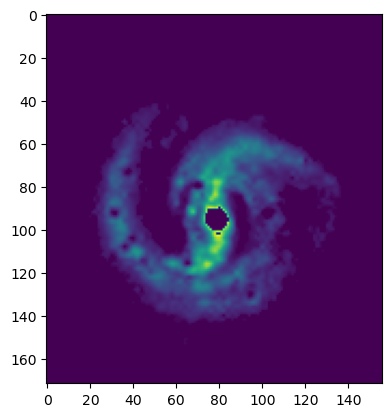

In [39]:
# This seems less reliable
thresh_mask = gfits.threshold_image(img,bulge_intensity-30*np.std(img))

plt.imshow(thresh_mask*img)

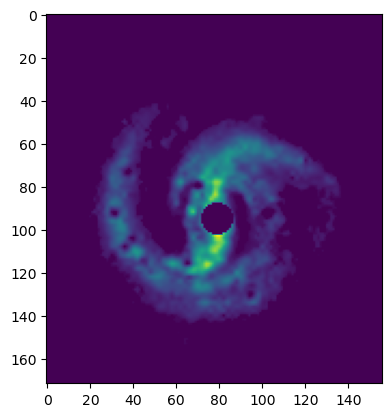

In [40]:
# Will instead try multiples of the effective radius
Re = 10**tbl['log_re']
multiple = 0.25
Re_mask = np.empty((img.shape[0],img.shape[1]))
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        if np.sqrt((j-bulge_pos[0,1])**2 + (i-bulge_pos[0,0])**2) < multiple*Re:
            Re_mask[i,j] = 0
        else:
            Re_mask[i,j] = 1
            
plt.figure()
plt.imshow(Re_mask*img)

# Quater of the effective radius looks promising will test on all bands

In [41]:
def R_e_bulge_mask(image,table):
    """
    Generates a mask for a given image based on a table of parameters related to a bulge.

    The mask is generated by calculating the Euclidean distance between each pixel in the image and the position
    of the brightest pixel (assumed to be the center of the bulge) in the image. Pixels within a certain distance
    (determined by a factor of the effective radius, Re) from the bulge center are set to zero in the mask, while
    pixels outside this distance are set to one. The resulting masked image is obtained by element-wise multiplication
    of the original image with the generated mask.

    Args:
        image (numpy.ndarray): A 2D numpy array representing the input image.
        table (dict or structured array): A dictionary or structured array containing the parameters related to the
                                         bulge, including the effective radius (Re), which is used to determine
                                         the size of the mask.

    Returns:
        numpy.ndarray: A masked version of the input image, where pixels within a certain distance from the center of
                       the bulge are set to zero and pixels outside this distance are preserved. The resulting masked
                       image has the same shape as the input image.
    """
    bulge_intensity = np.max(image)
    bulge_pos = np.asarray(np.argwhere(image == bulge_intensity))
    Re = 10**table['log_re']
    multiple = 0.3
    Re_mask = np.empty((image.shape[0],image.shape[1]))
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            if np.sqrt((j-bulge_pos[0,1])**2 + (i-bulge_pos[0,0])**2) < multiple*Re:
                Re_mask[i,j] = 0
            else:
                Re_mask[i,j] = 1
    return image*Re_mask


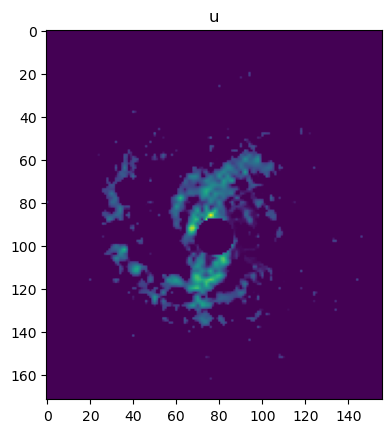

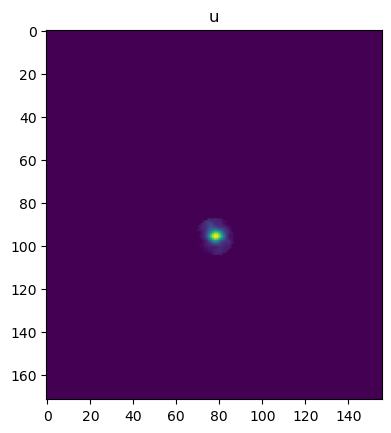

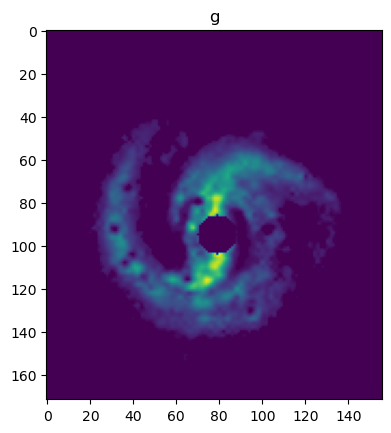

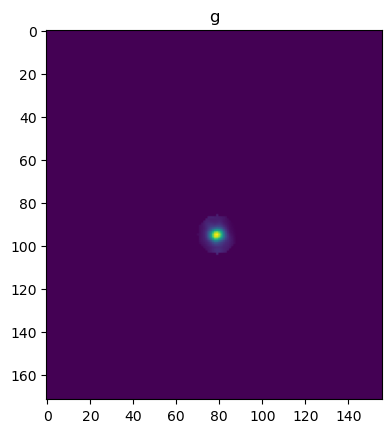

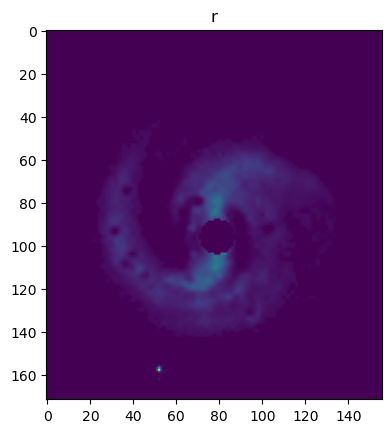

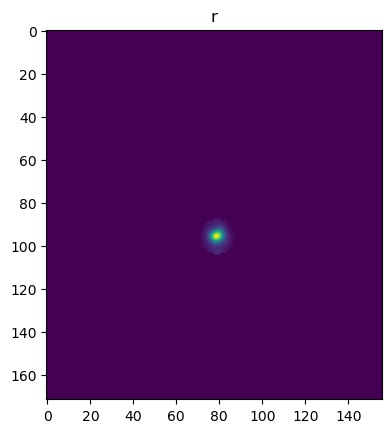

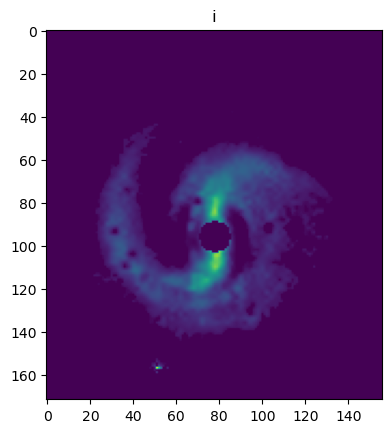

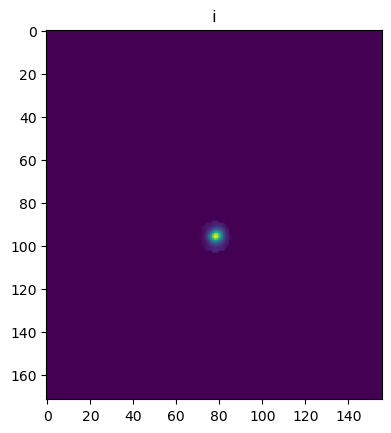

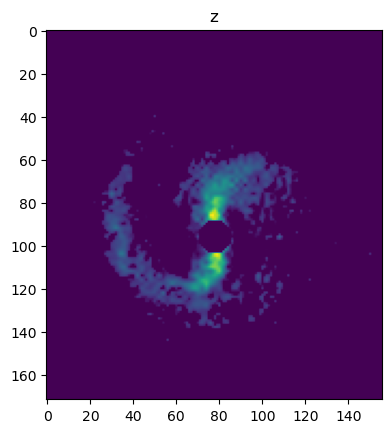

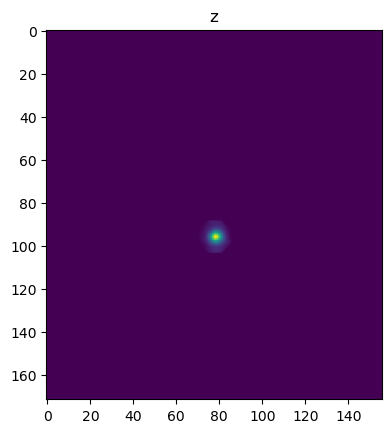

In [78]:
for i in range(0,len(bands)):
    plt.figure()
    masked_image = gfits.R_e_bulge_mask(comp[:,:,i],table[i])
    plt.title('{}'.format(bands[i]))
    plt.imshow(masked_image)
    plt.figure()
    masked_image = gfits.R_e_bulge_mask(comp[:,:,i],table[i],Bulge=True)
    plt.title('{}'.format(bands[i]))
    plt.imshow(masked_image)

In [ ]:
# Test on some other images

table1, comp1 = gfits.Composite_from_directory_raid('588017978348077077','/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/')

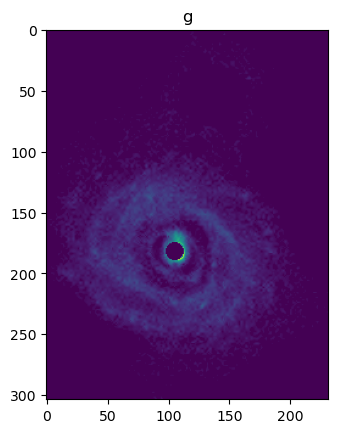

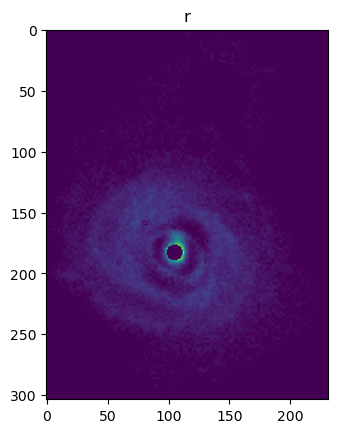

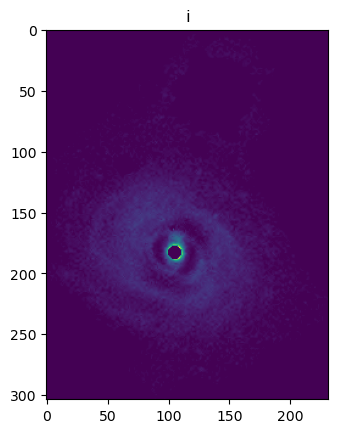

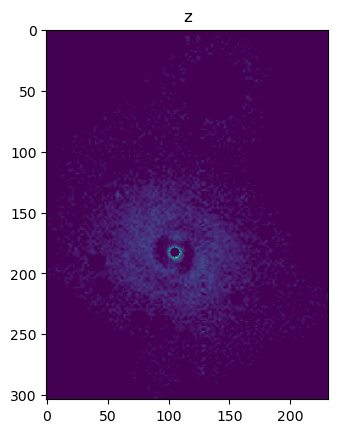

In [ ]:
for i in range(1,len(bands)):
    plt.figure()
    masked_image = R_e_bulge_mask(comp1[:,:,i],table1[i])
    plt.title('{}'.format(bands[i]))
    plt.imshow(masked_image)

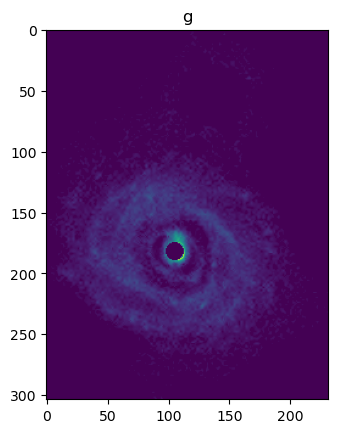

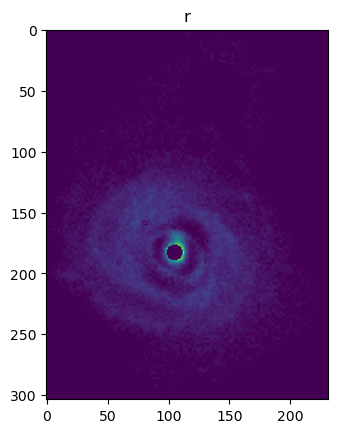

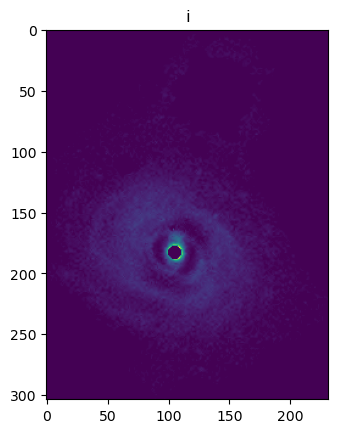

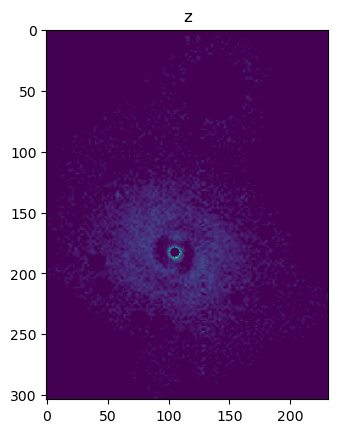

In [ ]:
for i in range(1,len(bands)):
    plt.figure()
    masked_image = gfits.R_e_bulge_mask(comp1[:,:,i],table1[i],Bulge=False)
    plt.title('{}'.format(bands[i]))
    plt.imshow(masked_image)

In [ ]:
# Now add function to flux fraction
def flux_frac(Composite,table,Composite_isolated):
    """
    Calculates the flux fraction between a composite image and an isolated composite image for each band.

    Args:
    - Composite (np.ndarray): A 3D numpy array of the composite image.
    - Composite_isolated (np.ndarray): A 3D numpy array of the isolated composite image.

    Returns:
    - flux_fraction (np.ndarray): A 1D numpy array containing the flux fraction for each band.
    """
    # Need to modify this so that it takes away the pixels exactly equal to 1000 and not 1000 from pixels 
    background_value = 1000.0
    counters = np.empty_like(wavs).astype(int)
    for i in range(0,len(bands)):
        for j in range(0,Composite[:,:,i].shape[0]-1):
            for s in range(0,Composite[:,:,i].shape[1]-1):
                if Composite[s,j,i] == 1000:
                    counters[i] =+ 1
                
    
    # Mask out the bulge
    Composite_isolated_m = np.empty_like(Composite_isolated)
    for i in range(0,len(bands)):
        Composite_isolated_m[:,:,i] = R_e_bulge_mask(Composite_isolated[:,:,i],table[i])
    
    flux_fraction = np.empty_like(wavs).astype(float)

    for i in range(0,len(bands)):
        flux_fraction[i] = np.sum(Composite_isolated_m[:,:,i])/(np.sum(Composite[:,:,i])-counters[i]*background_value)
    
    print(flux_fraction)
    return flux_fraction

In [ ]:
table_t, comp_t = gfits.Composite_from_directory_raid('588015510347448339','/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/')
org_t = gfits.Read_M_band('588015510347448339','/home/borge/Data/Brightest_1000/Brightest_1000_Spirals/')

fractions = gfits.flux_frac(comp_t,org_t)
#org_t.shape

[2.05833592e-312 2.05833592e-312 2.05833592e-312 2.05833592e-312
 2.05833592e-312]
[2879.57892305  278.93154174  200.26254022  169.43593027  423.83228568]


In [ ]:
img = comp_t[:,:,1]
Tab = table_t[1]
# First collect image info from Table
x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
log_R_e = np.asarray(Tab['log_re']) # log effective radius
#log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
pa = np.asarray(Tab['theta']) # position angle
q = np.asarray(Tab['q']) # axis ratio


# Get the dimensions of the Image
height, width = img.shape[:2]   

# Calculate the maximum possible radius
max_radius = min(x0, y0, width-x0, height-y0)
max_R = max_radius -1

# Create x and y index arrays
y, x = np.indices(img.shape)

# Center index arrays
x -= x0
y -= y0

# Deprojecting x,y by a series of affine transformations

# Rotate by minus position angle
ct = np.cos(-pa)
st = np.sin(-pa)

# Stretch according to axis ratio and rotation
xp = (y * ct + x * st) / q
yp = (-y * st + x * ct)

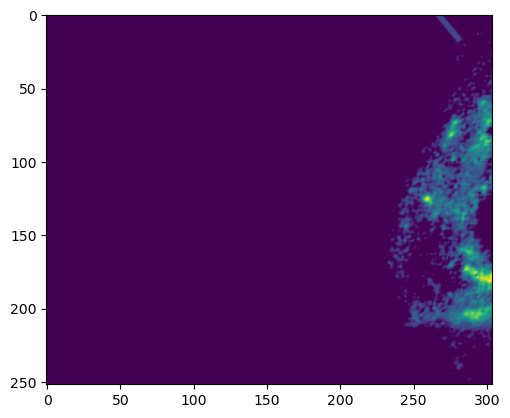

In [ ]:
from scipy.ndimage import map_coordinates

# Assuming img is the original image data and xp, yp are the deprojected x and y arrays

# Define the coordinates for interpolation
coords = np.array([yp, xp])

# Interpolate the values from the original image
deprojected_img = map_coordinates(img, coords, order=1, mode='nearest')
plt.figure()
plt.imshow(deprojected_img, cmap='viridis')

In [ ]:
import numpy as np
from scipy.ndimage import rotate
from scipy.interpolate import RectBivariateSpline

def deproject_galaxy_image(image, center, position_angle, axis_ratio):
    """
    Deprojects a galaxy image based on position angle, axis ratio, and center coordinates.

    Args:
        image (ndarray): Input galaxy image.
        center (tuple): Center coordinates (x, y) of the galaxy in the image.
        position_angle (float): Position angle (in degrees) of the galaxy.
        axis_ratio (float): Axis ratio of the galaxy.

    Returns:
        ndarray: Deprojected galaxy image.
    """
    # Convert position angle to radians
    theta = np.deg2rad(position_angle)

    # Shift the galaxy center to the origin
    x, y = center
    image_centered = np.roll(np.roll(image, -y+image.shape[0]//2, axis=0), -x+image.shape[1]//2, axis=1)

    # Create a grid of coordinates centered at the origin
    xx, yy = np.meshgrid(np.arange(-image.shape[1]//2, image.shape[1]//2), np.arange(-image.shape[0]//2, image.shape[0]//2))

    # Rotate the grid by the position angle
    xx_rot = xx * np.cos(theta) + yy * np.sin(theta)
    yy_rot = -xx * np.sin(theta) + yy * np.cos(theta)

    # Scale the rotated grid by the axis ratio
    xx_scaled = xx_rot / axis_ratio
    yy_scaled = yy_rot * axis_ratio

    # Interpolate the deprojected image from the scaled grid to the original grid
    deprojected_image = RectBivariateSpline(yy_scaled[:, 0], xx_scaled[0, :], image_centered)(yy[:, 0], xx[0, :])

    return deprojected_image


In [ ]:
centre = (int(img.shape[1]/2 + np.asarray(Tab['x'])),int(img.shape[0]/2 + np.asarray(Tab['y'])))
pa = float(Tab['theta'])
q = float(Tab['q'])
centre,pa,q

((154, 123), -0.6909728331440934, 0.766381999772131)

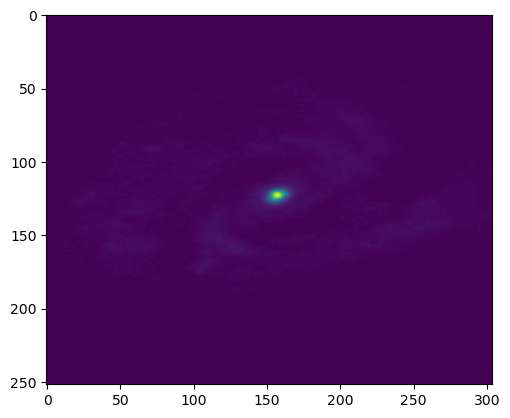

In [ ]:
dep_im = deproject_galaxy_image(img,centre,pa,q)
plt.imshow(dep_im)

5.08331996746211

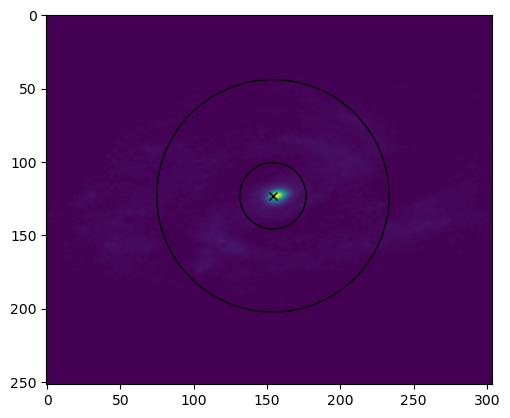

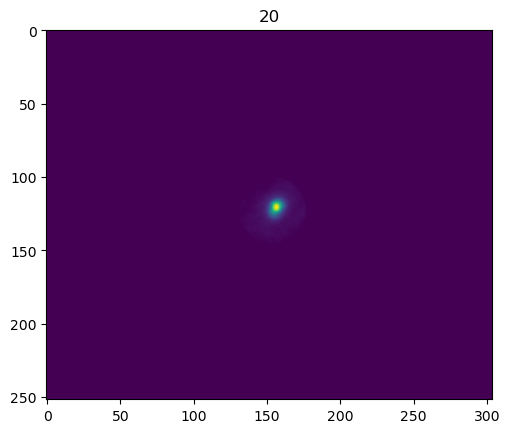

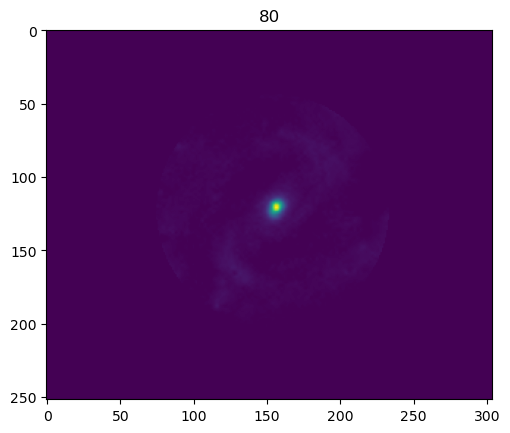

In [ ]:
# Now we have deprojected we need CAS

# C

img = comp_t[:,:,1]
Tab = table_t[1]

centre = (int(img.shape[1]/2 + np.asarray(Tab['x'])),int(img.shape[0]/2 + np.asarray(Tab['y'])))

# 'approximations commonly used in astronomy'

Re = 10**Tab['log_re']
R20 = 0.4*Re
R80 = 1.4*Re

dep_im = deproject_galaxy_image(img,centre,pa,q)

R20_patch = Circle(centre,R20,fill=None)
R80_patch = Circle(centre,R80,fill=None)

fig, ax = plt.subplots()
ax.imshow(dep_im)
ax.plot(centre[0],centre[1],'kx')
ax.add_patch(R20_patch)
ax.add_patch(R80_patch)

R20_mask = np.empty_like(img)
R80_mask = np.empty_like(img)
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        if np.sqrt((i-centre[1])**2+(j-centre[0])**2) < R20:
            R20_mask[i,j] = 1
        else:
            R20_mask[i,j] = 0
    
        if np.sqrt((i-centre[1])**2+(j-centre[0])**2) < R80:
            R80_mask[i,j] = 1
        else:
            R80_mask[i,j] = 0


R20_img = img*R20_mask
R80_img = img*R80_mask

plt.figure()
plt.title('20')
plt.imshow(R20_img)
plt.figure()
plt.title('80')
plt.imshow(R80_img)


C = 5*np.log(np.sum(R80_img)/np.sum(R20_img))
C

In [ ]:
# A

img = comp_t[:,:,1]
Tab = table_t[1]

centre = (int(img.shape[1]/2 + np.asarray(Tab['x'])),int(img.shape[0]/2 + np.asarray(Tab['y'])))
pa = float(Tab['theta'])
q = float(Tab['q'])

dep_im = deproject_galaxy_image(img,centre,pa,q)

rotated_im = np.rot90(dep_im,2)

A = np.sum(np.abs(dep_im-rotated_im))/np.sum(dep_im)

A # done

1.1027079601568408

In [ ]:
# S
from skimage.measure import shannon_entropy

# Normalise dep_im

norm_dep_im = dep_im/np.max(dep_im)

high_freq_structures = shannon_entropy(norm_dep_im)
total_flux = np.sum(norm_dep_im)

S = high_freq_structures/total_flux
S


0.03680612151852722

In [ ]:
# Nice now combine into one function which acts on an image and a table

def CAS(image,table):
    
    # gather Information
    img = image
    Tab = table
    centre = (int(img.shape[1]/2 + np.asarray(Tab['x'])),int(img.shape[0]/2 + np.asarray(Tab['y'])))
    pa = float(Tab['theta'])
    q = float(Tab['q'])

    # 'approximations commonly used in astronomy'

    Re = 10**Tab['log_re']
    R20 = 0.4*Re
    R80 = 1.4*Re

    # Deproject image
    
    dep_im = deproject_galaxy_image(img,centre,pa,q)

    # Create concentration masks
    
    R20_mask = np.empty_like(img)
    R80_mask = np.empty_like(img)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if np.sqrt((i-centre[1])**2+(j-centre[0])**2) < R20:
                R20_mask[i,j] = 1
            else:
                R20_mask[i,j] = 0
        
            if np.sqrt((i-centre[1])**2+(j-centre[0])**2) < R80:
                R80_mask[i,j] = 1
            else:
                R80_mask[i,j] = 0

    R20_img = dep_im*R20_mask
    R80_img = dep_im*R80_mask

    C = 5*np.log10(np.sum(R20_img)/np.sum(R80_img))
    
    rotated_im = np.rot90(dep_im,2)

    A = np.sum(np.abs(dep_im-rotated_im))/np.sum(dep_im)
    
    # Normalise dep_im

    norm_dep_im = dep_im/np.max(dep_im)

    high_freq_structures = shannon_entropy(norm_dep_im)
    total_flux = np.sum(norm_dep_im)

    S = high_freq_structures/total_flux
    
    return C,A,S
    
    
    
    

In [ ]:
C,A,S = CAS(comp_t[:,:,1],table_t[1])
C,A,S

(-2.094966309554371, 1.1027079601568408, 0.03680612151852722)